In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/SHA256SUMS.txt
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/RECORDS
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/README
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/CONTROLS
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/ptb.png
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0038lre.dat
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0026lre.xyz
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0029lre.xyz
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0026lre.dat
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0026lre.hea
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0038lre.hea
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0078lre.xyz
/kagg

In [2]:
import os
import re

In [3]:
os.system('pip install mrmr-selection')

from mrmr import mrmr_classif

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
os.system('pip install PyWavelets')
import pywt

In [6]:
os.system('pip install wfdb')
import wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.3 MB/s eta 0:00:00


In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model

2025-11-10 17:54:08.606305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762797248.799643      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762797248.867128      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


---

# **EDA**
Here we analyze the data.

In [9]:
def list_subdirectories(path):
    try:
        if not os.path.isdir(path):
            print(f"Error: The path '{path}' is not a valid directory.")
            return None

        entries = os.listdir(path)
        subdirectories = [entry for entry in entries if os.path.isdir(os.path.join(path, entry))]
        subdirectories.sort()
        
        return subdirectories

    except FileNotFoundError:
        print(f"Error: The path '{path}' was not found.")
        return None
    except PermissionError:
        print(f"Error: Permission denied to access '{path}'.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [10]:
path = "/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/"
subdirectories = list_subdirectories(path)
patients = pd.DataFrame(subdirectories)
patients

,0
0,patient001
1,patient002
2,patient003
3,patient004
4,patient005
...,...
285,patient290
286,patient291
287,patient292
288,patient293


In [11]:
def find_hea_files_in_subdirs(base_path):
    
    subdirs = list_subdirectories(base_path)
    if subdirs is None:
        return None

    hea_files_by_dir = {}

    for subdir in subdirs:
        try:
            subdir_path = os.path.join(base_path, subdir)
            all_files = os.listdir(subdir_path)
            
            hea_files = [f for f in all_files if f.endswith('.hea') and os.path.isfile(os.path.join(subdir_path, f))]
            hea_files.sort()
            
            hea_files_by_dir[subdir] = hea_files
        except PermissionError:
            print(f"Warning: Permission denied for directory '{subdir}'. Skipping.")
            hea_files_by_dir[subdir] = ["--> Permission Denied"]
        except Exception as e:
            print(f"Warning: Could not process directory '{subdir}': {e}. Skipping.")
            hea_files_by_dir[subdir] = [f"--> Error: {e}"]
            
    return hea_files_by_dir

In [12]:
patients_header = find_hea_files_in_subdirs(path)
patients_header

{'patient001': ['s0010_re.hea', 's0014lre.hea', 's0016lre.hea'],
 'patient002': ['s0015lre.hea'],
 'patient003': ['s0017lre.hea'],
 'patient004': ['s0020are.hea', 's0020bre.hea'],
 'patient005': ['s0021are.hea',
  's0021bre.hea',
  's0025lre.hea',
  's0031lre.hea',
  's0101lre.hea'],
 'patient006': ['s0022lre.hea', 's0027lre.hea', 's0064lre.hea'],
 'patient007': ['s0026lre.hea',
  's0029lre.hea',
  's0038lre.hea',
  's0078lre.hea'],
 'patient008': ['s0028lre.hea', 's0037lre.hea', 's0068lre.hea'],
 'patient009': ['s0035_re.hea'],
 'patient010': ['s0036lre.hea', 's0042lre.hea', 's0061lre.hea'],
 'patient011': ['s0039lre.hea',
  's0044lre.hea',
  's0049lre.hea',
  's0067lre.hea'],
 'patient012': ['s0043lre.hea', 's0050lre.hea'],
 'patient013': ['s0045lre.hea', 's0051lre.hea', 's0072lre.hea'],
 'patient014': ['s0046lre.hea', 's0056lre.hea', 's0071lre.hea'],
 'patient015': ['s0047lre.hea', 's0057lre.hea', 's0152lre.hea'],
 'patient016': ['s0052lre.hea', 's0060lre.hea', 's0076lre.hea'],
 'pa

In [13]:
def extract_localization_from_files(hea_data, base_path):
    
    data_by_patient = {}
    
    if not hea_data:
        return {}

    for directory, file_list in hea_data.items():
        
        grouped_by_info = {}

        for file_name in file_list:
            full_path = os.path.join(base_path, directory, file_name)
            
            acute_loc = "Not specified"
            former_loc = "Not specified"
            disease = "Not specified"
            age = "Not specified"
            sex = "Not specified"
            smoker = "Not specified"
            vessels = "Not specified"
            additional_diagnoses = "Not specified"


            if file_name.startswith("-->"):
                
                acute_loc, former_loc, disease, age, sex, smoker, vessels, additional_diagnoses = ["N/A (Previous error)"] * 8
            else:
                try:
                    with open(full_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        
                        # Extract all fields using regex
                        acute_match = re.search(r'# Acute infarction \(localization\): (.*)', content)
                        if acute_match: acute_loc = acute_match.group(1).strip()
                        
                        former_match = re.search(r'# Former infarction \(localization\): (.*)', content)
                        if former_match: former_loc = former_match.group(1).strip()
                        
                        dis_match = re.search(r'# Reason for admission: (.*)', content)
                        if dis_match: disease = dis_match.group(1).strip()

                        age_match = re.search(r'# age: (.*)', content)
                        if age_match: age = age_match.group(1).strip()

                        sex_match = re.search(r'# sex: (.*)', content)
                        if sex_match: sex = sex_match.group(1).strip()

                        smoker_match = re.search(r'# Smoker: (.*)', content)
                        if smoker_match: smoker = smoker_match.group(1).strip()

                        vessels_match = re.search(r'# Number of coronary vessels involved: (.*)', content)
                        if vessels_match: vessels = vessels_match.group(1).strip()

                        additional_dx_match = re.search(r'# Additional diagnoses: (.*)', content)
                        if additional_dx_match: additional_diagnoses = additional_dx_match.group(1).strip()

                except Exception as e:
                    acute_loc, former_loc, disease, age, sex, smoker, vessels, additional_diagnoses = [f"--> Error: {e}"] * 8
            
            info_tuple = (acute_loc, former_loc, disease, age, sex, smoker, vessels, additional_diagnoses)
            if info_tuple not in grouped_by_info:
                grouped_by_info[info_tuple] = []
            grouped_by_info[info_tuple].append(file_name)
        
        patient_summary_list = []
        for info, files in grouped_by_info.items():
            
            unpacked_info = info
            patient_summary_list.append(unpacked_info + (len(files), files))
            
        data_by_patient[directory] = patient_summary_list
            
    return data_by_patient

In [14]:
patients_localization = extract_localization_from_files(patients_header,path)
patients_localization

{'patient001': [('infero-latera',
   'no',
   'Myocardial infarction',
   '81',
   'female',
   'no',
   '1',
   'Diabetes mellitus',
   3,
   ['s0010_re.hea', 's0014lre.hea', 's0016lre.hea'])],
 'patient002': [('anterior',
   'no',
   'Myocardial infarction',
   '58',
   'female',
   'yes',
   '1',
   'Arterial hypertension, Adiposis hepatis, Gastritis',
   1,
   ['s0015lre.hea'])],
 'patient003': [('infero-postero-lateral',
   'no',
   'Myocardial infarction',
   '63',
   'male',
   'yes',
   '1',
   'no',
   1,
   ['s0017lre.hea'])],
 'patient004': [('antero-septal',
   'no',
   'Myocardial infarction',
   '69',
   'male',
   'no',
   '1',
   'Arterial hypertension, Obesity',
   2,
   ['s0020are.hea', 's0020bre.hea'])],
 'patient005': [('anterior',
   'no',
   'Myocardial infarction',
   '74',
   'male',
   'no',
   '2',
   'Skoliosis',
   5,
   ['s0021are.hea',
    's0021bre.hea',
    's0025lre.hea',
    's0031lre.hea',
    's0101lre.hea'])],
 'patient006': [('anterior',
   'inferi

In [15]:
def convert_to_dataframe(patient_data):
    
    try:
        import pandas as pd
    except ImportError:
        return None

    data_for_df = []
    for patient, summary_list in patient_data.items():
        if summary_list:
            for data_tuple in summary_list:
                (acute_loc, former_loc, disease, age, sex, smoker, 
                 vessels, additional_diagnoses, count, files) = data_tuple
                
                data_for_df.append({
                    'patient': patient,
                    'age': age,
                    'sex': sex,
                    'disease': disease,
                    'acute_localization': acute_loc,
                    'former_localization': former_loc,
                    'additional_diagnoses': additional_diagnoses,
                    'smoker': smoker,
                    'vessels_involved': vessels,
                    'file_count': count,
                    'hea_files': ", ".join(files)
                })
        else:
            data_for_df.append({
                'patient': patient,
                'age': 'N/A',
                'sex': 'N/A',
                'disease': 'N/A',
                'acute_localization': 'N/A',
                'former_localization': 'N/A',
                'additional_diagnoses': 'N/A',
                'smoker': 'N/A',
                'vessels_involved': 'N/A',
                'file_count': 0,
                'hea_files': ''
            })

    return pd.DataFrame(data_for_df)

In [16]:
patient_details = convert_to_dataframe(patients_localization)
patient_details.head()

,patient,age,sex,disease,acute_localization,former_localization,additional_diagnoses,smoker,vessels_involved,file_count,hea_files
0,patient001,81,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,no,1,3,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",yes,1,1,s0015lre.hea
2,patient003,63,male,Myocardial infarction,infero-postero-lateral,no,no,yes,1,1,s0017lre.hea
3,patient004,69,male,Myocardial infarction,antero-septal,no,"Arterial hypertension, Obesity",no,1,2,"s0020are.hea, s0020bre.hea"
4,patient005,74,male,Myocardial infarction,anterior,no,Skoliosis,no,2,5,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."


In [17]:
patient_details.isin([np.nan,"unknown","no","","N/A","n/a","?","-"]).sum()/patient_details.shape[0] * 100

patient                  0.000000
age                      5.172414
sex                      3.103448
disease                  7.586207
acute_localization      56.206897
former_localization     84.137931
additional_diagnoses    40.689655
smoker                  74.827586
vessels_involved        54.482759
file_count               0.000000
hea_files                0.000000
dtype: float64

Dealing with **disease** data imbalance.

In [18]:
patient_detail = patient_details.drop(columns=['vessels_involved','file_count','smoker'])
final_patient_details = patient_detail.copy()
final_patient_details.loc[~final_patient_details['disease'].isin(["Myocardial infarction", "Healthy control"]), 'disease'] = 'other'
final_patient_details

,patient,age,sex,disease,acute_localization,former_localization,additional_diagnoses,hea_files
0,patient001,81,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",s0015lre.hea
2,patient003,63,male,Myocardial infarction,infero-postero-lateral,no,no,s0017lre.hea
3,patient004,69,male,Myocardial infarction,antero-septal,no,"Arterial hypertension, Obesity","s0020are.hea, s0020bre.hea"
4,patient005,74,male,Myocardial infarction,anterior,no,Skoliosis,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."
...,...,...,...,...,...,...,...,...
285,patient290,60,male,Myocardial infarction,antero-septal,inferior,unknown,s0553_re.hea
286,patient291,69,male,Myocardial infarction,inferior,inferior,unknown,s0554_re.hea
287,patient292,66,male,Myocardial infarction,antero-lateral,no,Arterial hypertension,"s0555_re.hea, s0556_re.hea"
288,patient293,75,male,Myocardial infarction,antero-lateral,no,unknown,"s0557_re.hea, s0558_re.hea"


In [19]:
final_patient_details.isin([np.nan,"unknown","no","","N/A","n/a","?","-"]).sum()/final_patient_details.shape[0] * 100

patient                  0.000000
age                      5.172414
sex                      3.103448
disease                  0.000000
acute_localization      56.206897
former_localization     84.137931
additional_diagnoses    40.689655
hea_files                0.000000
dtype: float64

In [20]:
patients = final_patient_details.replace('n/a', np.nan)

Dealing with **age** data imbalance.

In [21]:
patients['age'] = SimpleImputer(strategy='mean').fit_transform(patients[['age']])
patients

,patient,age,sex,disease,acute_localization,former_localization,additional_diagnoses,hea_files
0,patient001,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58.0,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",s0015lre.hea
2,patient003,63.0,male,Myocardial infarction,infero-postero-lateral,no,no,s0017lre.hea
3,patient004,69.0,male,Myocardial infarction,antero-septal,no,"Arterial hypertension, Obesity","s0020are.hea, s0020bre.hea"
4,patient005,74.0,male,Myocardial infarction,anterior,no,Skoliosis,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."
...,...,...,...,...,...,...,...,...
285,patient290,60.0,male,Myocardial infarction,antero-septal,inferior,unknown,s0553_re.hea
286,patient291,69.0,male,Myocardial infarction,inferior,inferior,unknown,s0554_re.hea
287,patient292,66.0,male,Myocardial infarction,antero-lateral,no,Arterial hypertension,"s0555_re.hea, s0556_re.hea"
288,patient293,75.0,male,Myocardial infarction,antero-lateral,no,unknown,"s0557_re.hea, s0558_re.hea"


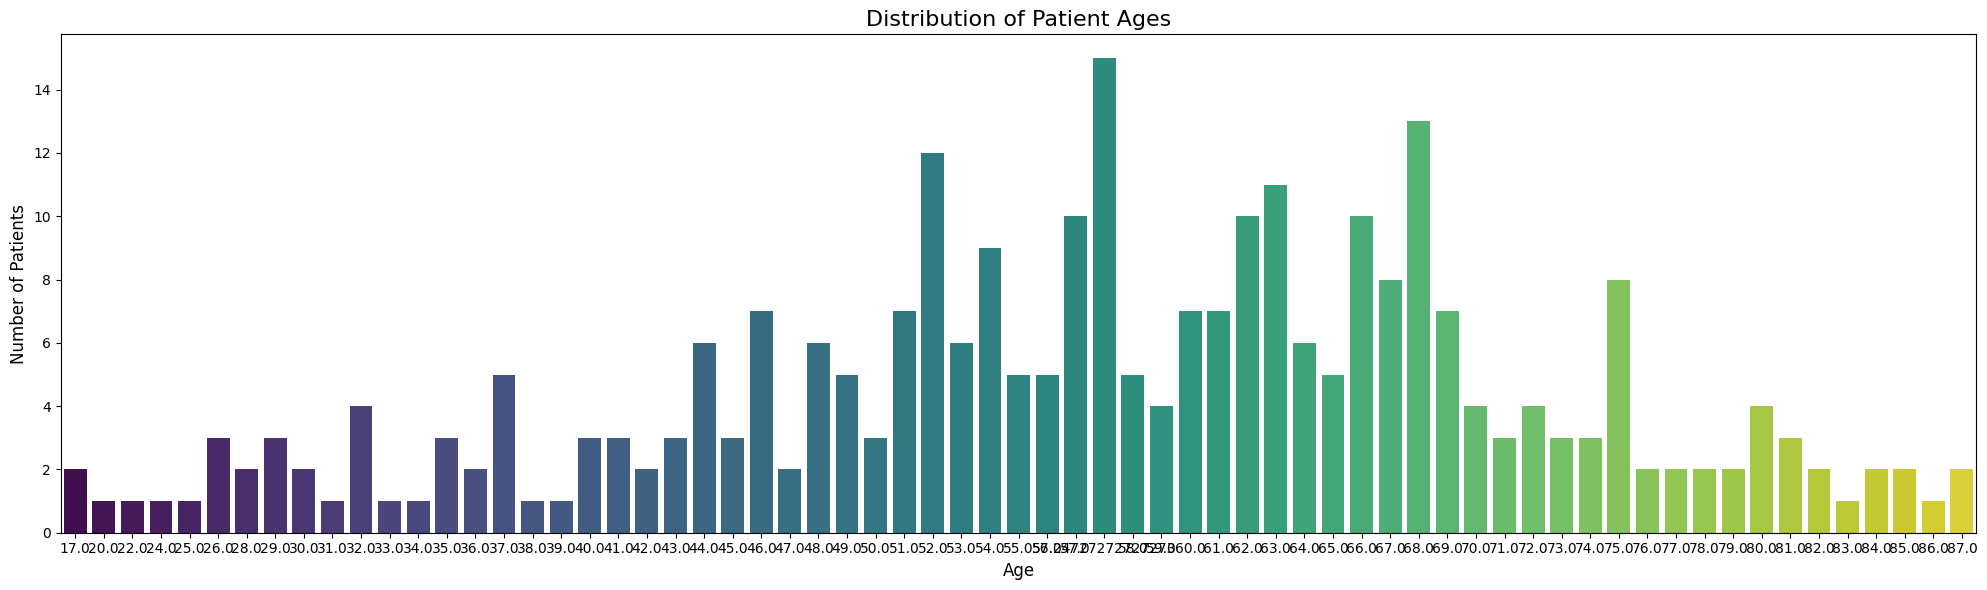

In [22]:
plt.figure(figsize=(20, 6))
sns.countplot(x='age', data=patients, palette='viridis')

plt.title('Distribution of Patient Ages', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.tight_layout() # Adjust layout to make room for labels

plt.show()

Dealing with **sex** data imbalance.

In [23]:
patients.loc[~patients['sex'].isin(["male", "female"]), 'sex'] = 'other'

In [24]:
patients.sex.value_counts()

sex
male      200
female     81
other       9
Name: count, dtype: int64

Dealing with **acute_localization** data imbalance.

In [25]:
patients.acute_localization.value_counts()

acute_localization
no                        140
inferior                   30
antero-septal              27
infero-lateral             22
anterior                   17
antero-lateral             16
infero-postero-lateral      7
postero-lateral             2
infero-latera               1
infero-poster-lateral       1
lateral                     1
posterior                   1
infero-posterior            1
antero-septo-lateral        1
unknown                     1
Name: count, dtype: int64

In [26]:
localization_map = {
    'no': 'NO',
    'inferior': 'IMI',
    'antero-septal': 'ASMI',
    'infero-lateral': 'ILMI',
    'anterior': 'AMI',
    'antero-lateral': 'ALMI',
    'infero-postero-lateral': 'IPLMI',
    'postero-lateral': 'PLMI',
    'infero-latera': 'ILMI',
    'infero-poster-lateral': 'IPLMI',
    'lateral': 'LMI',
    'posterior': 'PMI',
    'infero-posterior': 'IPMI',
    'antero-septo-lateral': 'ASLMI',
    'unknown': np.nan
}

patients['acute_localization'] = patients['acute_localization'].str.strip().str.lower()
patients['acute_localization'] = patients['acute_localization'].replace(localization_map)
patients = patients.dropna(subset=['acute_localization'])
patients['acute_localization'].value_counts()

acute_localization
NO       140
IMI       30
ASMI      27
ILMI      23
AMI       17
ALMI      16
IPLMI      8
PLMI       2
LMI        1
PMI        1
IPMI       1
ASLMI      1
Name: count, dtype: int64

Dealing with **former_localization** data imbalance.

In [27]:
patients.former_localization.value_counts()

former_localization
no                                    209
anterior                               14
inferior                               13
unknown                                12
infero-posterior                        3
antero-lateral                          3
infero-lateral                          2
anterior (1), inferior (2)              2
postero-lateral                         1
anterior (1), anterior (2)              1
inferior ?                              1
antero-septal                           1
antero-septal ?                         1
infero-postero-lateral                  1
anterior ?                              1
infero-posterior (1), inferior (2)      1
inferior (1+2)                          1
Name: count, dtype: int64

In [28]:
localization_map = {
    'no': 'NO',
    'anterior': 'AMI',
    'inferior': 'IMI',
    'unknown' : np.nan,
    'infero-posterior': 'IPMI',
    'antero-lateral': 'ALMI',
    'infero-lateral': 'ILMI',
    'anterior (1), inferior (2)': 'AMI IMI',
    'antero-septal ?': 'ASMI',
    'infero-posterior (1), inferior (2)': 'IPMI IMI',
    'anterior ?': 'AMI',
    'infero-postero-lateral': 'IPMI',
    'anterior (1), anterior (2)': 'AMI',
    'inferior ?': 'IMI',
    'postero-lateral': 'PLMI',
    'antero-septal': 'ASMI',
    'inferior (1+2)': 'IMI'
}
patients = patients.copy()
patients['former_localization'] = patients['former_localization'].replace(localization_map)
patients['former_localization'] = patients['former_localization'].fillna("other")
patients['former_localization'].value_counts()

former_localization
NO          209
AMI          16
IMI          15
other        12
IPMI          4
ALMI          3
ASMI          2
AMI IMI       2
ILMI          2
PLMI          1
IPMI IMI      1
Name: count, dtype: int64

In [29]:
patients['former_localization'].isin([np.nan]).sum()

0

Dealing with **additional_diagnoses** data imbalance.

In [30]:
patients.head()

,patient,age,sex,disease,acute_localization,former_localization,additional_diagnoses,hea_files
0,patient001,81.0,female,Myocardial infarction,ILMI,NO,Diabetes mellitus,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58.0,female,Myocardial infarction,AMI,NO,"Arterial hypertension, Adiposis hepatis, Gastr...",s0015lre.hea
2,patient003,63.0,male,Myocardial infarction,IPLMI,NO,no,s0017lre.hea
3,patient004,69.0,male,Myocardial infarction,ASMI,NO,"Arterial hypertension, Obesity","s0020are.hea, s0020bre.hea"
4,patient005,74.0,male,Myocardial infarction,AMI,NO,Skoliosis,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."


In [31]:
patients.additional_diagnoses.value_counts()

additional_diagnoses
no                                                                                                          81
unknown                                                                                                     14
Arterial hypertension                                                                                       14
Hypercholesterinemia                                                                                         5
Hyperlipoproteinemia Type IV                                                                                 4
                                                                                                            ..
M. Bechterew                                                                                                 1
Arterial hypertension, Hyperlipemia, Ventricular fibrillation                                                1
Hypercholesterinemia, Ventricular fibrillation                                             

Removing additional_diagnosis as the data is highly unique.

In [32]:
patients = patients.drop(columns=['additional_diagnoses'])
patients.head()

,patient,age,sex,disease,acute_localization,former_localization,hea_files
0,patient001,81.0,female,Myocardial infarction,ILMI,NO,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58.0,female,Myocardial infarction,AMI,NO,s0015lre.hea
2,patient003,63.0,male,Myocardial infarction,IPLMI,NO,s0017lre.hea
3,patient004,69.0,male,Myocardial infarction,ASMI,NO,"s0020are.hea, s0020bre.hea"
4,patient005,74.0,male,Myocardial infarction,AMI,NO,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."


---

# **Preprocessing**
## *Demonstrating the preprocessing steps for one patient.*

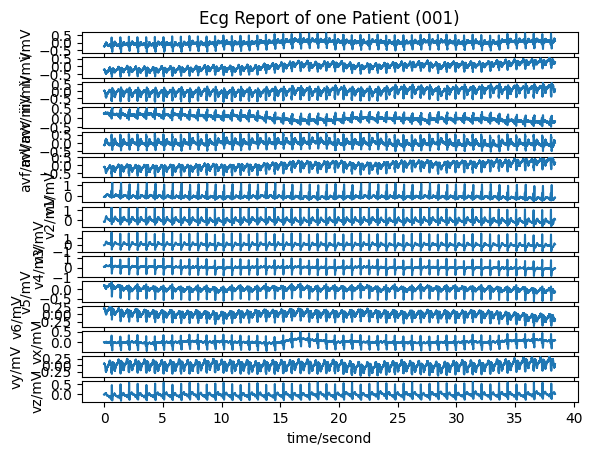

In [33]:
record = wfdb.rdrecord('/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re') 
wfdb.plot_wfdb(record=record, title='Ecg Report of one Patient (001)') 

## *Using only lead (II and III)*

In [34]:
signals, fields = wfdb.rdsamp('/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient030/s0117lre', channels=[1,2])
raw_ecg_data = pd.DataFrame(signals, columns=['lead_ii', 'lead_iii'])
print("Successfully loaded the ECG signal data.")
raw_ecg_data

Successfully loaded the ECG signal data.


,lead_ii,lead_iii
0,-1.0225,-0.8380
1,-1.0290,-0.8380
2,-1.0195,-0.8210
3,-1.0320,-0.8290
4,-1.0340,-0.8335
...,...,...
115195,2.0295,1.7850
115196,2.0300,1.7865
115197,2.0295,1.7825
115198,2.0285,1.7955


## *Using DWT to Filter Out the Frequencies*

We use **level = 9**, as for **fs = 1000 Hz**, we need to go up to level 9 to isolate the **< 0.5 Hz** band.

#### Frequency Bands for fs = 1000 Hz (approximate)

- **cA9:** 0 – 0.97 Hz → Contains baseline wander (< 0.5 Hz)
<br> **------------------ Lower Cutoff is here (≈ 0.97 Hz) ------------------**
- **cD9:** 0.97 – 1.95 Hz  
- **cD8:** 1.95 – 3.9 Hz  
- **cD7:** 3.9 – 7.8 Hz  
- **cD6:** 7.8 – 15.6 Hz  
- **cD5:** 15.6 – 31.25 Hz  
- **cD4:** 31.25 – 62.5 Hz
<br> **------------------ Upper Cutoff is here (≈ 62.5 Hz) ------------------**
- **cD3:** 62.5 – 125 Hz  
- **cD2:** 125 – 250 Hz  
- **cD1:** 250 – 500 Hz  


In [35]:
def denoise_signal_dwt(signal, fs):
    
    wavelet = 'db6'
    level = 9
    
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    coeffs[0] = np.zeros_like(coeffs[0])  # Remove cA9 (< 0.97 Hz)
    coeffs[-1] = np.zeros_like(coeffs[-1]) # Remove cD1 (> 250 Hz)
    coeffs[-2] = np.zeros_like(coeffs[-2]) # Remove cD2 (> 125 Hz)
    coeffs[-3] = np.zeros_like(coeffs[-3]) # Remove cD3 (> 62.5 Hz)
    # coeffs[-4] = np.zeros_like(coeffs[-4]) # Remove cD4 (> 31.25 Hz)
    # coeffs[-5] = np.zeros_like(coeffs[-5]) # Remove cD5 (> 15.6 Hz)
    
    denoised_signal = pywt.waverec(coeffs, wavelet)

    output_len = len(signal)
    if len(denoised_signal) > output_len:
        return denoised_signal[:output_len] # Truncate if longer
    else:
        return np.pad(denoised_signal, (0, output_len - len(denoised_signal)), 'edge')

Denoising signals using DWT...
Plotting a sample of the denoising effect for Lead II...


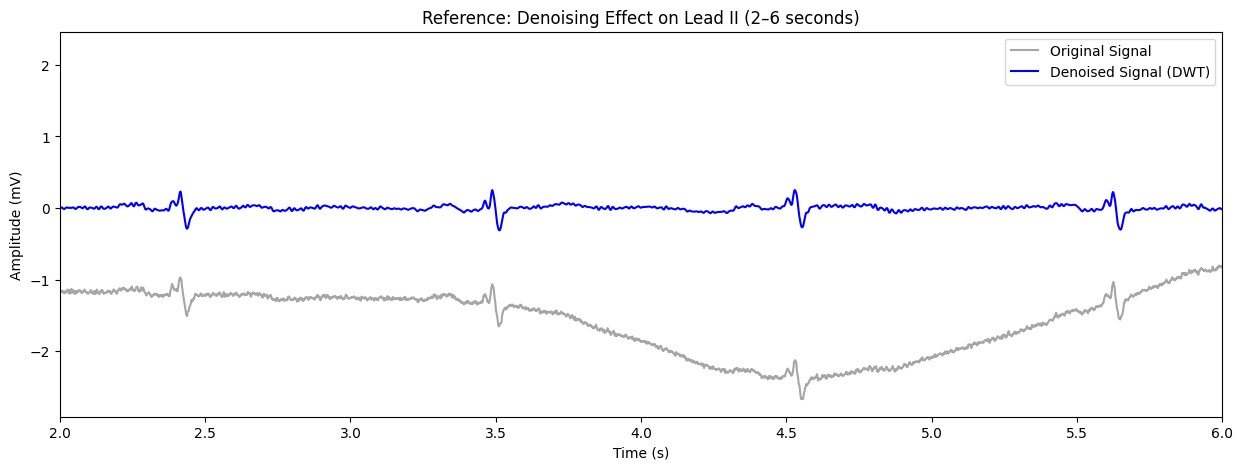

Plotting a sample of the denoising effect for Lead III...


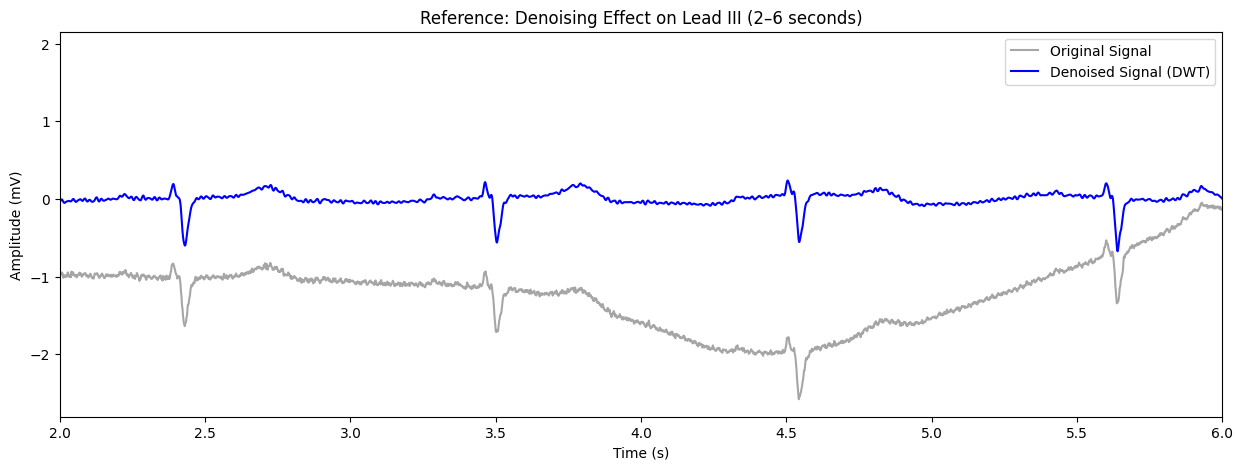

In [39]:
fs = fields['fs']

signal_lead_ii = pd.Series(signals[:, 0]).bfill().values
signal_lead_iii = pd.Series(signals[:, 1]).bfill().values

print("Denoising signals using DWT...")
denoised_lead_ii = denoise_signal_dwt(signal_lead_ii, fs)
denoised_lead_iii = denoise_signal_dwt(signal_lead_iii, fs)

# Plot Lead II
print("Plotting a sample of the denoising effect for Lead II...")
plt.figure(figsize=(15, 5))
plt.title("Reference: Denoising Effect on Lead II (2–6 seconds)")
time_ref = np.arange(len(signal_lead_ii)) / fs
plt.plot(time_ref, signal_lead_ii, 'gray', alpha=0.7, label='Original Signal')
plt.plot(time_ref, denoised_lead_ii, 'b', label='Denoised Signal (DWT)')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.xlim(2, 6)
plt.legend()
plt.show()

# Plot Lead III
print("Plotting a sample of the denoising effect for Lead III...")
plt.figure(figsize=(15, 5))
plt.title("Reference: Denoising Effect on Lead III (2–6 seconds)")
time_ref = np.arange(len(signal_lead_iii)) / fs
plt.plot(time_ref, signal_lead_iii, 'gray', alpha=0.7, label='Original Signal')
plt.plot(time_ref, denoised_lead_iii, 'b', label='Denoised Signal (DWT)')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.xlim(2, 6)
plt.legend()
plt.show()


## *Here we apply Pan Tompkins Detector Algorithm.*

In [40]:
def pan_tompkins_detector(signal, fs):
    
    # Stages 2-5 of Pan-Tompkins: Derivative, Squaring, Integration, Thresholding
    derivative_signal = np.diff(signal) * fs
    derivative_signal = np.insert(derivative_signal, 0, derivative_signal[0])
    squared_signal = derivative_signal**2
    window_size = int(0.010 * fs)
    integrated_signal = np.convolve(squared_signal, np.ones(window_size)/window_size, mode='same')
    
    r_peaks = []
    noise_peak = np.mean(integrated_signal[:int(2*fs)])
    signal_peak = np.max(integrated_signal[:int(2*fs)])
    threshold = noise_peak + 0.25 * (signal_peak - noise_peak)
    min_rr_interval = int(0.5 * fs)
    last_r_peak_sample = - min_rr_interval
    
    for i in range(1, len(integrated_signal) - 1):
        if integrated_signal[i] > integrated_signal[i-1] and integrated_signal[i] > integrated_signal[i+1]:
            peak_sample = i
            peak_value = integrated_signal[peak_sample]
            if peak_value > threshold:
                if (peak_sample - last_r_peak_sample) > min_rr_interval:
                    r_peaks.append(peak_sample)
                    last_r_peak_sample = peak_sample
                    signal_peak = 0.125 * peak_value + 0.875 * signal_peak
                elif(integrated_signal[r_peaks[-1]]<peak_value):
                    r_peaks[-1] = peak_sample
                    last_r_peak_sample = peak_sample
                    signal_peak = 0.125 * peak_value + 0.875 * signal_peak
            else:
                noise_peak = 0.125 * peak_value + 0.875 * noise_peak
            threshold = noise_peak + 0.25 * (signal_peak - noise_peak)
            
    return r_peaks, integrated_signal


Detecting R-peaks from Lead II...
Found 109 R-peaks.

Plotting Denoised vs. Integrated signal with R-Peaks...


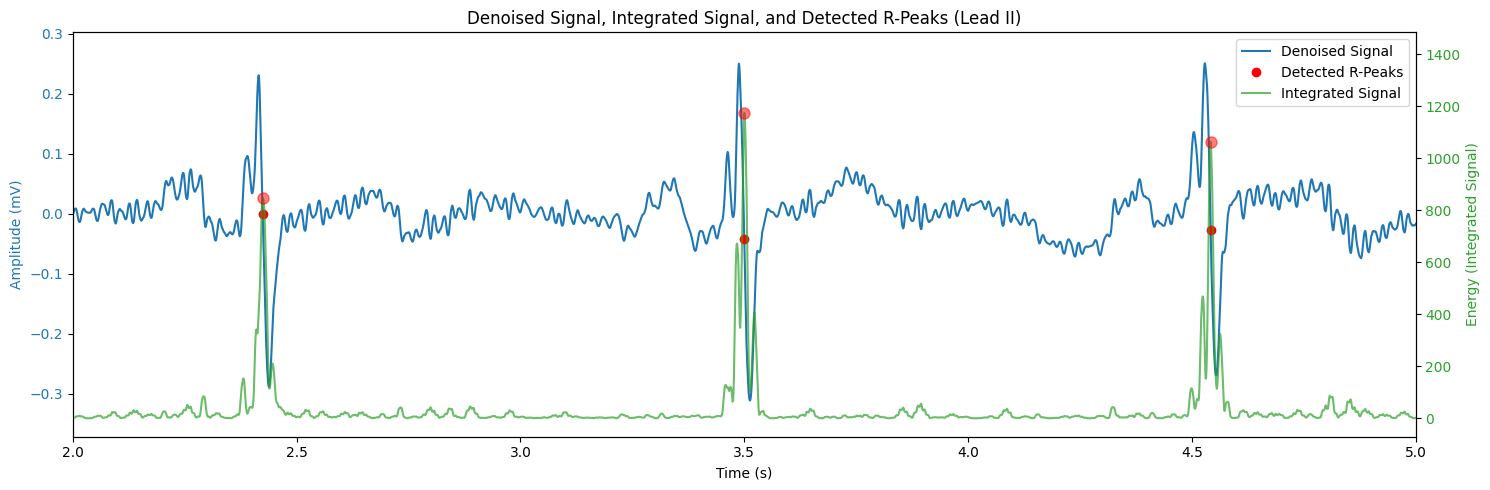

In [41]:
print("\nDetecting R-peaks from Lead II...")
r_peaks_ii, integrated_signal_ii = pan_tompkins_detector(denoised_lead_ii, fs)
print(f"Found {len(r_peaks_ii)} R-peaks.")

print("\nPlotting Denoised vs. Integrated signal with R-Peaks...")
fig, ax1 = plt.subplots(figsize=(15, 5))
plt.title("Denoised Signal, Integrated Signal, and Detected R-Peaks (Lead II)")
time_vec = np.arange(len(denoised_lead_ii)) / fs

color = 'tab:blue'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (mV)', color=color)
ax1.plot(time_vec, denoised_lead_ii, color=color, label='Denoised Signal')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(2, 5)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Energy (Integrated Signal)', color=color)
ax2.plot(time_vec, integrated_signal_ii, color=color, label='Integrated Signal', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

ax1.plot(time_vec[r_peaks_ii], denoised_lead_ii[r_peaks_ii], 'ro', label='Detected R-Peaks')
ax2.plot(time_vec[r_peaks_ii], integrated_signal_ii[r_peaks_ii], 'ro', markersize=8, alpha=0.5)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

fig.tight_layout()
plt.show()

Center padded the Segmented beats

In [ ]:
# ------------------------- Center Padding of the Beats -----------------------
# def segment_beats(signal, r_peaks):
    # """
    # Segments a signal into individual beats and pads them with zeros 
    # to ensure they all have the same length.
    # """
    # segmented_beats = []
    # # We cannot segment the first or the last beat with this method
    # for i in range(1, len(r_peaks) - 1):
    #     r_current = r_peaks[i]
    #     r_previous = r_peaks[i-1]
        
    #     # Calculate the previous R-R interval
    #     rr_interval = r_current - r_previous
        
    #     # Segment boundaries are 1/3 before R-peak and 2/3 after
    #     start_beat = r_current - int(rr_interval * (1/3))
    #     end_beat = r_current + int(rr_interval * (2/3))
        
    #     # Ensure the segment is within the signal bounds
    #     if start_beat >= 0 and end_beat < len(signal):
    #         beat = signal[start_beat:end_beat]
    #         segmented_beats.append(beat)
            
    # if not segmented_beats:
    #     return []

    # # Find the length of the longest beat
    # max_len = max(len(beat) for beat in segmented_beats)
    
    # # Pad all beats to the length of the longest beat
    # padded_beats = []
    # for beat in segmented_beats:
    #     padding_needed = max_len - len(beat)
    #     # Pad to the middle by distributing padding on both sides
    #     pad_left = padding_needed // 2
    #     pad_right = padding_needed - pad_left
    #     padded_beat = np.pad(beat, (pad_left, pad_right), 'constant', constant_values=0)
    #     padded_beats.append(padded_beat)
            
    # return padded_beats
# -------------------------------------------------------------------------------

Padded the segmented beats to reduce variation.

In [ ]:
# -------------------- Variable Padding of the Beats ----------------------------
# def segment_beats(signal, r_peaks):
    
#     segmented_beats = []
#     r_peak_locations_in_beat = []

#     # --- Step 1: Segment beats and find relative R-peak positions ---
#     for i in range(1, len(r_peaks) - 1):
#         r_current = r_peaks[i]
#         r_previous = r_peaks[i-1]
        
#         rr_interval = r_current - r_previous
        
#         start_beat = r_current - int(rr_interval * (1/3))
#         end_beat = r_current + int(rr_interval * (2/3))
        
#         if start_beat >= 0 and end_beat < len(signal):
#             beat = signal[start_beat:end_beat]
#             segmented_beats.append(beat)
            
#             # The R-peak is at 1/3rd of the interval from the start of the segment
#             r_loc = int(rr_interval * (1/3))
#             r_peak_locations_in_beat.append(r_loc)
            
#     if not segmented_beats:
#         return []

#     # --- Step 2: Calculate average R-peak position and max length ---
#     average_r_peak_position = int(np.mean(r_peak_locations_in_beat))
#     max_len = max(len(beat) for beat in segmented_beats)
    
#     padded_beats = []
#     # --- Step 3: Pad each beat to align R-peaks ---
#     for i, beat in enumerate(segmented_beats):
#         current_r_peak_pos = r_peak_locations_in_beat[i]
#         padding_needed = max_len - len(beat)
        
#         # Calculate the ideal left padding to align the R-peak
#         ideal_pad_left = average_r_peak_position - current_r_peak_pos
        
#         # Constrain the left padding to be within the available padding (0 to padding_needed)
#         pad_left = max(0, min(ideal_pad_left, padding_needed))
        
#         # The rest of the padding goes to the right
#         pad_right = padding_needed - pad_left
        
#         padded_beat = np.pad(beat, (pad_left, pad_right), 'constant', constant_values=0)
#         padded_beats.append(padded_beat)
            
#     return padded_beats
# ----------------------------------------------------------------------------------

Padded the Segmented Beats to remove outliers and reduce variation.

In [42]:
def segment_beats(signal, r_peaks, max_len=None):

    if len(r_peaks) < 3:
        return []

    rr_intervals = np.diff(r_peaks)

    # IQR method for outlier removal to identify which beats to process
    q1 = np.percentile(rr_intervals, 25)
    q3 = np.percentile(rr_intervals, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # If max_len is not provided (standalone mode), calculate it locally.
    if max_len is None:
        normal_rr_intervals = [rr for rr in rr_intervals if lower_bound <= rr <= upper_bound]
        if not normal_rr_intervals:
            return []
        max_len = max(normal_rr_intervals)

    segmented_beats = []
    r_peak_locations_in_beat = [] 

    for i in range(1, len(r_peaks) - 1):
        r_current = r_peaks[i]
        r_previous = r_peaks[i-1]
        
        rr_interval = r_current - r_previous
        
        # Only process beats where the PRECEDING interval is normal
        if not (lower_bound <= rr_interval <= upper_bound):
            continue

        start_beat = r_current - int(rr_interval * (1/3))
        end_beat = r_current + int(rr_interval * (2/3))
        
        if start_beat >= 0 and end_beat < len(signal):
            beat = signal[start_beat:end_beat]
            segmented_beats.append(beat)
            
            # The R-peak is at 1/3rd of the interval from the start of the segment
            r_loc = int(rr_interval * (1/3))
            r_peak_locations_in_beat.append(r_loc)
            
    if not segmented_beats:
        return []

    average_r_peak_position = int(np.mean(r_peak_locations_in_beat))
    
    padded_beats = []
    for i, beat in enumerate(segmented_beats):
        current_r_peak_pos = r_peak_locations_in_beat[i]
        
        # Padding is based on the max_len (either global or local)
        padding_needed = max_len - len(beat)
        
        if padding_needed < 0:
            beat = beat[:max_len]
            padding_needed = 0

        ideal_pad_left = average_r_peak_position - current_r_peak_pos
        pad_left = max(0, min(ideal_pad_left, padding_needed))
        pad_right = padding_needed - pad_left
        
        if pad_right < 0: pad_right = 0
        
        padded_beat = np.pad(beat, (pad_left, pad_right), 'constant', constant_values=0)
        
        if len(padded_beat) > max_len:
            padded_beat = padded_beat[:max_len]
            
        padded_beats.append(padded_beat)
            
    return padded_beats

In [43]:
print("\nSegmenting beats from Lead III...")
segmented_beats_iii = segment_beats(denoised_lead_iii, r_peaks_ii)
print(f"Segmented {len(segmented_beats_iii)} beats.")


Segmenting beats from Lead III...
Segmented 105 beats.



Generating final pipeline plots...


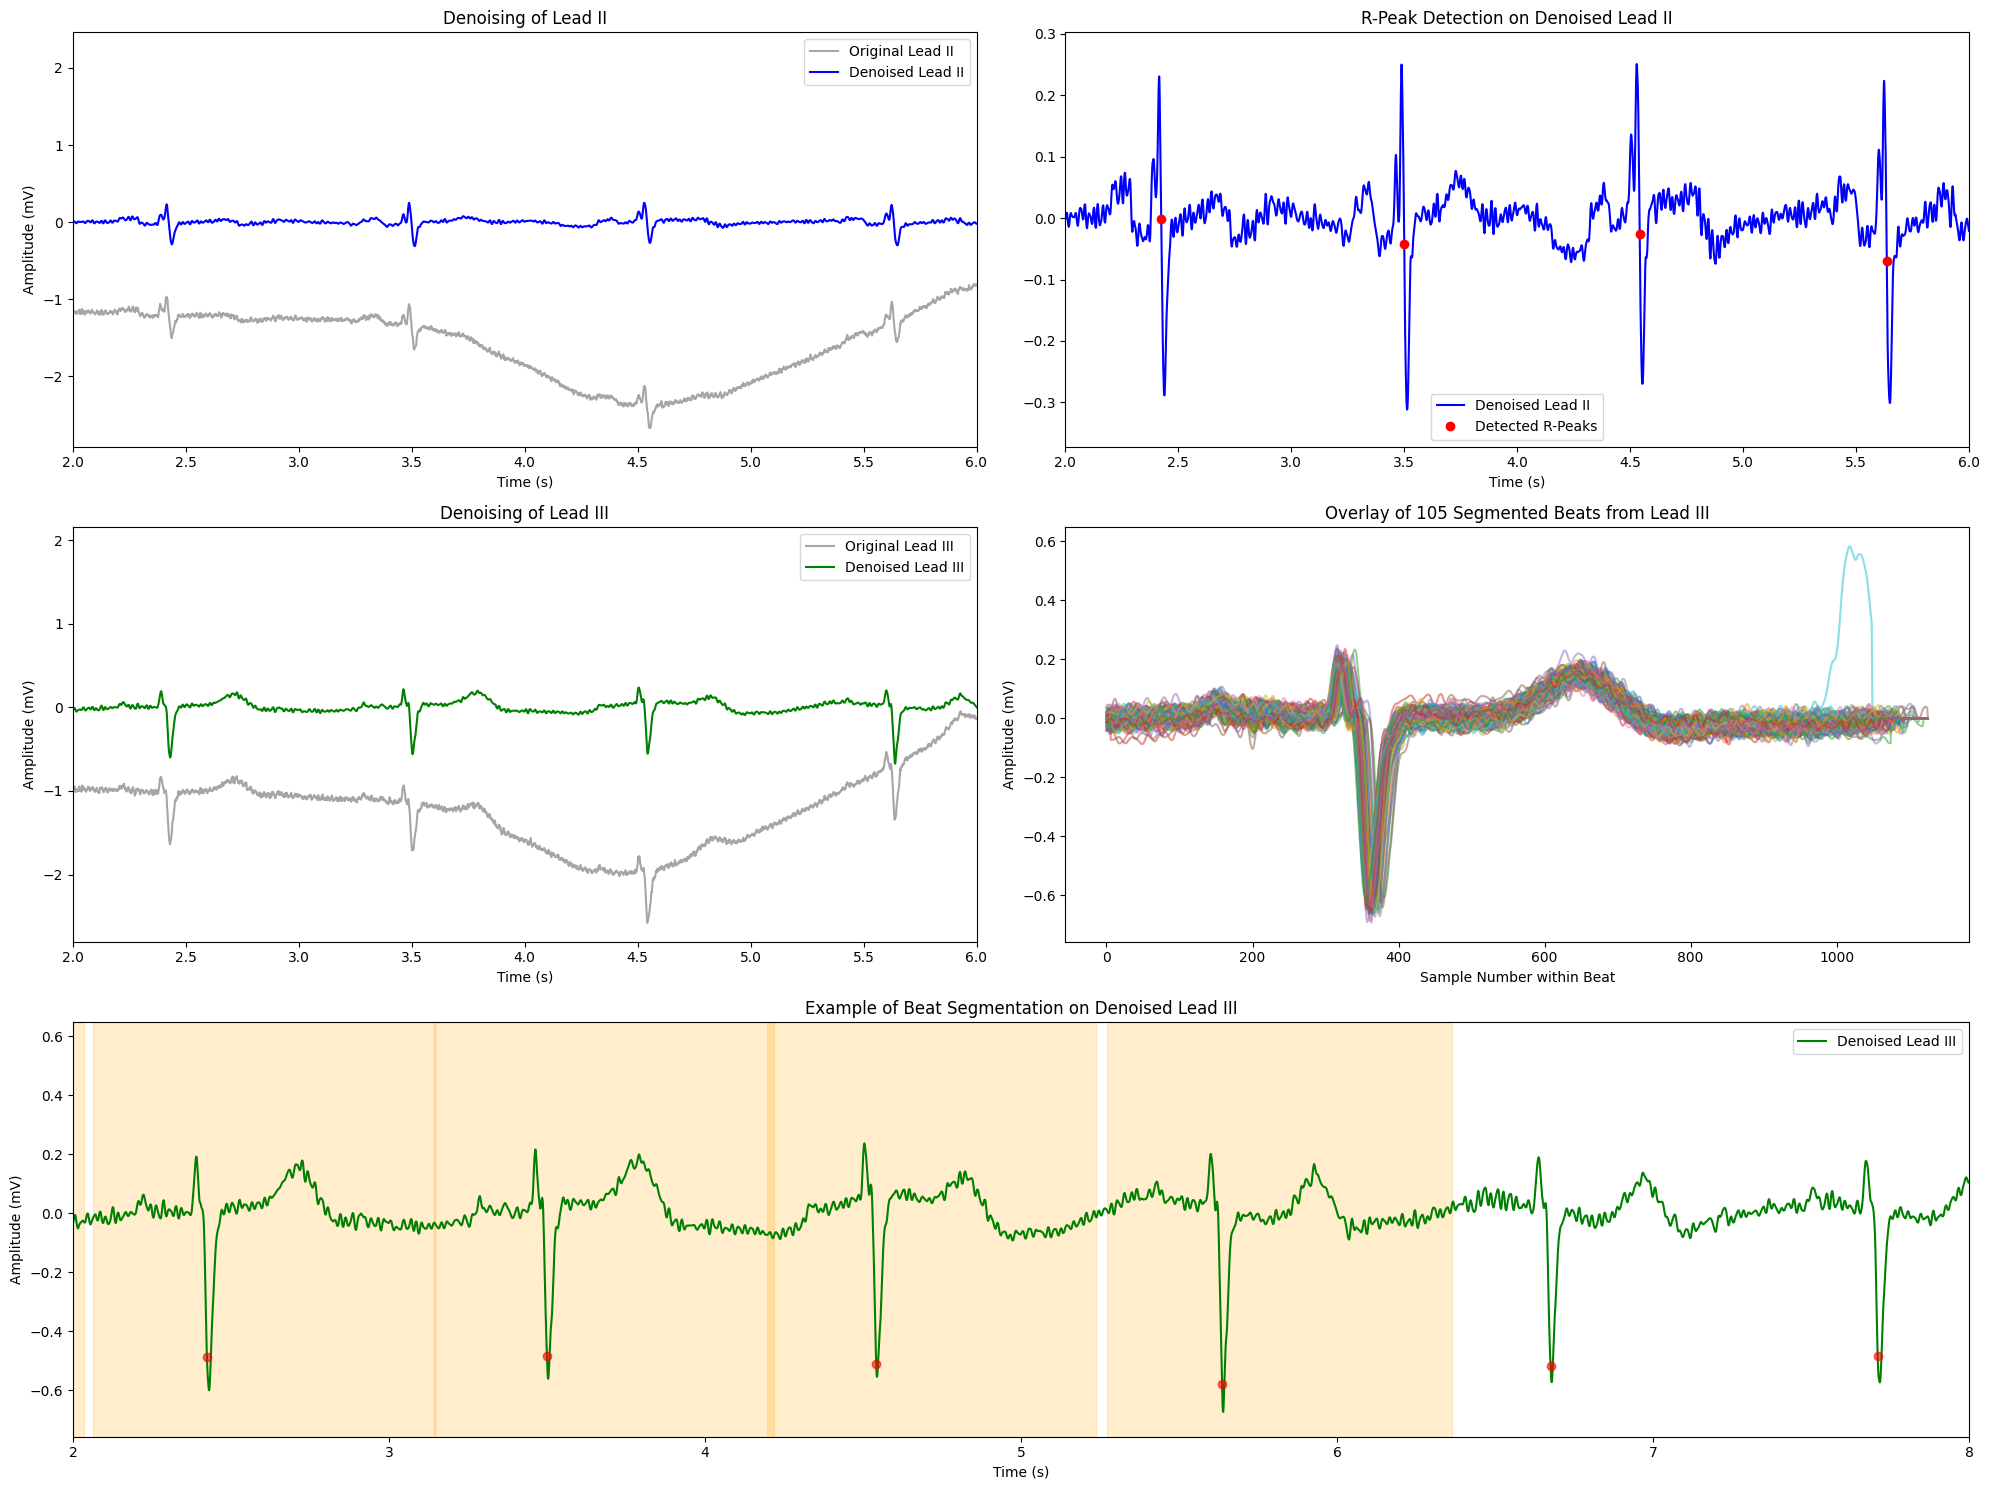

In [44]:
print("\nGenerating final pipeline plots...")
time_vector = np.arange(len(signal_lead_ii)) / fs
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 2)

# Plot 1: Denoising of Lead II
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time_vector, signal_lead_ii, 'gray', alpha=0.7, label='Original Lead II')
ax1.plot(time_vector, denoised_lead_ii, 'b', label='Denoised Lead II')
ax1.set_title('Denoising of Lead II')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (mV)')
ax1.legend()
ax1.set_xlim(2, 6)

# Plot 2: R-Peak Detection on Lead II
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time_vector, denoised_lead_ii, 'b', label='Denoised Lead II')
ax2.plot(time_vector[r_peaks_ii], denoised_lead_ii[r_peaks_ii], 'ro', label='Detected R-Peaks')
ax2.set_title('R-Peak Detection on Denoised Lead II')
ax2.set_xlabel('Time (s)')
ax2.legend()
ax2.set_xlim(2, 6)

# Plot 3: Denoising of Lead III
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(time_vector, signal_lead_iii, 'gray', alpha=0.7, label='Original Lead III')
ax3.plot(time_vector, denoised_lead_iii, 'g', label='Denoised Lead III')
ax3.set_title('Denoising of Lead III')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Amplitude (mV)')
ax3.legend()
ax3.set_xlim(2, 6)

# Plot 4: Overlay of Segmented Beats from Lead III
ax4 = fig.add_subplot(gs[1, 1])
ax4.set_title(f'Overlay of {len(segmented_beats_iii)} Segmented Beats from Lead III')
for beat in segmented_beats_iii:
    ax4.plot(beat, alpha=0.5)
ax4.set_xlabel('Sample Number within Beat')
ax4.set_ylabel('Amplitude (mV)')

# Plot 5: Detailed view of a few segmented beats
ax5 = fig.add_subplot(gs[2, :])
ax5.set_title('Example of Beat Segmentation on Denoised Lead III')
ax5.plot(time_vector, denoised_lead_iii, 'g', label='Denoised Lead III')
# Plot R-peaks for reference
ax5.plot(time_vector[r_peaks_ii], denoised_lead_iii[r_peaks_ii], 'ro', alpha=0.6)
# Highlight the segmented regions
for i in range(1, min(len(r_peaks_ii) - 1, 6)): # Show first 5 segments
    r_curr = r_peaks_ii[i]
    r_prev = r_peaks_ii[i-1]
    rr = r_curr - r_prev
    start = r_curr - int(rr * 1/3)
    end = r_curr + int(rr * 2/3)
    ax5.axvspan(start/fs, end/fs, color='orange', alpha=0.2)
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Amplitude (mV)')
ax5.set_xlim(2, 8)
ax5.legend()


plt.tight_layout()
plt.show()

In [45]:
def select_representative_beats(padded_beats, correlation_threshold=0.95):
    
    valid_beats = [beat for beat in padded_beats if np.std(beat) > 0]

    if len(valid_beats) < 2:
        return valid_beats, None, None, None

    beats_array = np.array(valid_beats)
    corr_matrix = np.corrcoef(beats_array)
    corr_matrix = np.nan_to_num(corr_matrix)
    mean_correlations = (np.sum(corr_matrix, axis=1) - 1) / (len(corr_matrix) - 1)
    max_mean_correlation = np.max(mean_correlations) if len(mean_correlations) > 0 else None

    representative_indices = np.where(mean_correlations > correlation_threshold)[0]
    
    if len(representative_indices) == 0 and len(mean_correlations) > 0:
        print(f"Warning: No beats passed the correlation threshold of {correlation_threshold}. Returning the single beat with the highest average correlation as a fallback.")
        representative_indices = [np.argmax(mean_correlations)]

    representative_beats = [valid_beats[i] for i in representative_indices]
    
    return representative_beats, corr_matrix, max_mean_correlation, mean_correlations

Segmented 105 beats with a uniform length of 1126 samples.

Selecting most representative beats based on correlation...
Selected 2 representative beats (mean correlation > 0.885).
Maximum mean correlation: 0.8886

Generating distribution plot of mean correlations...


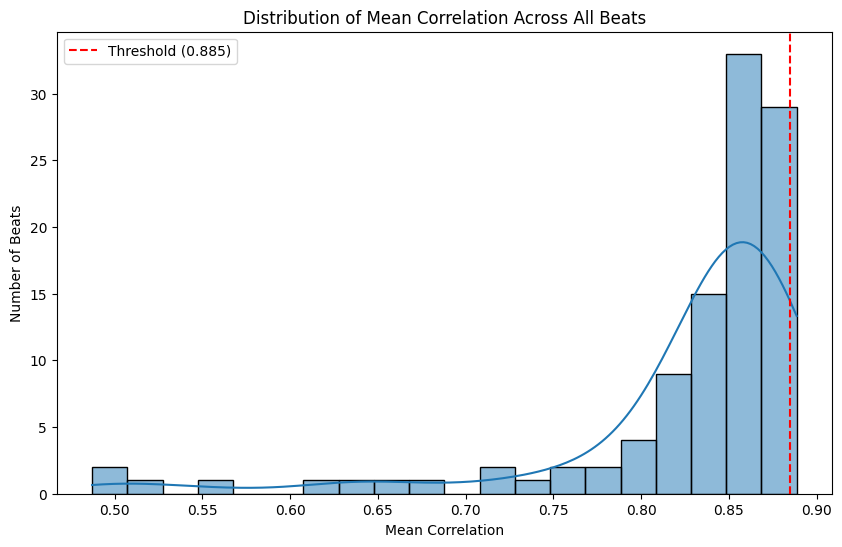


Generating correlation heatmap of all segmented beats...


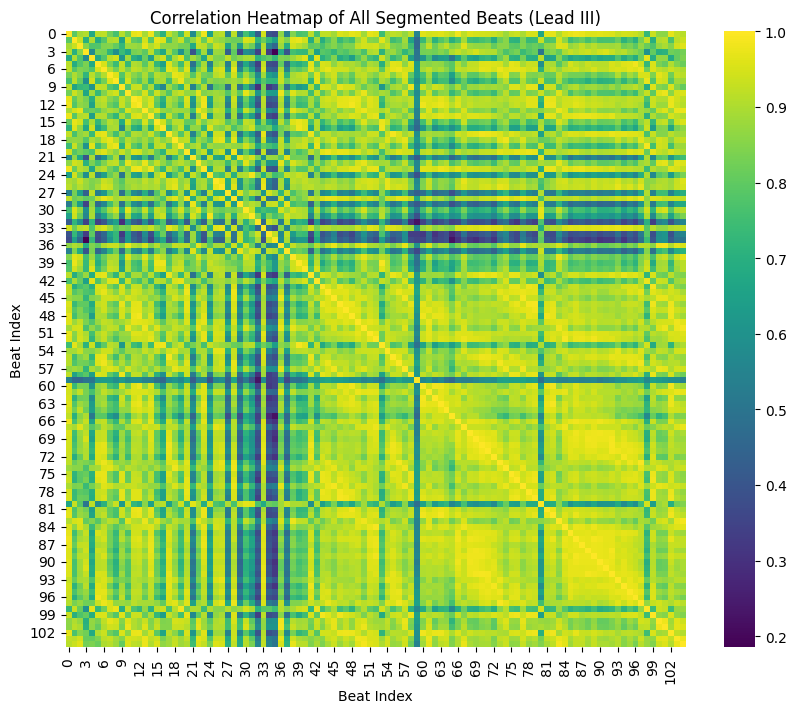


Generating final plot of representative beats...


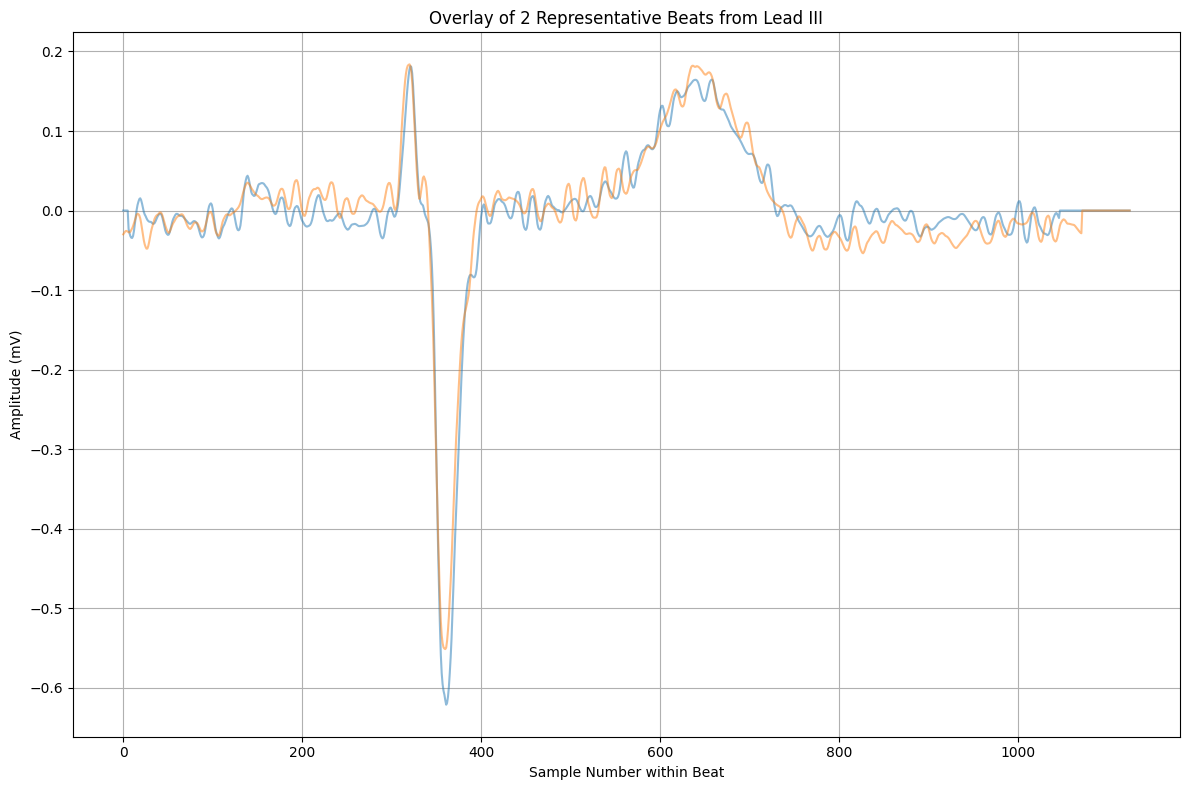

In [46]:
if segmented_beats_iii:
    print(f"Segmented {len(segmented_beats_iii)} beats with a uniform length of {len(segmented_beats_iii[0])} samples.")

    # --- Select Representative Beats AND get correlation data ---
    print("\nSelecting most representative beats based on correlation...")
    correlation_thresh = 0.885 # Heuristically chosen threshold
    representative_beats_iii, corr_matrix, max_mean_corr, all_mean_corrs = select_representative_beats(segmented_beats_iii, correlation_threshold=correlation_thresh)
    print(f"Selected {len(representative_beats_iii)} representative beats (mean correlation > {correlation_thresh}).")
    if max_mean_corr is not None:
        print(f"Maximum mean correlation: {max_mean_corr:.4f}")

    # --- PLOT: Distribution of Mean Correlations ---
    if all_mean_corrs is not None:
        print("\nGenerating distribution plot of mean correlations...")
        plt.figure(figsize=(10, 6))
        sns.histplot(all_mean_corrs, kde=True, bins=20)
        plt.axvline(correlation_thresh, color='r', linestyle='--', label=f'Threshold ({correlation_thresh})')
        plt.title('Distribution of Mean Correlation Across All Beats')
        plt.xlabel('Mean Correlation')
        plt.ylabel('Number of Beats')
        plt.legend()
        plt.show()
    
    # --- PLOT: Correlation Heatmap of All Segmented Beats ---
    if corr_matrix is not None:
        print("\nGenerating correlation heatmap of all segmented beats...")
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, cmap='viridis', annot=False)
        plt.title('Correlation Heatmap of All Segmented Beats (Lead III)')
        plt.xlabel('Beat Index')
        plt.ylabel('Beat Index')
        plt.show()
    if representative_beats_iii:
        print("\nGenerating final plot of representative beats...")
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_title(f'Overlay of {len(representative_beats_iii)} Representative Beats from Lead III')
        for beat in representative_beats_iii:
            ax.plot(beat, alpha=0.5)
        ax.set_xlabel('Sample Number within Beat')
        ax.set_ylabel('Amplitude (mV)')
        ax.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("Could not segment beats.")

In [47]:
class BeatExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, base_path, correlation_threshold):
        self.base_path = base_path
        self.global_max_len_ = 0
        self.correlation_threshold = correlation_threshold

    def fit(self, X, y=None):
        
        print("--- Fitting BeatExtractor: Determining Global Max Beat Length ---")
        for index, row in X.iterrows():
            patient_id, record_names = row['patient'], [rec.strip().replace('.hea', '') for rec in row['hea_files'].split(',')]
            for record_name in record_names:
                try:
                    record_path = os.path.join(self.base_path, patient_id, record_name)
                    signals, fields = wfdb.rdsamp(record_path, channels=[1])
                    fs, lead_ii_raw = fields['fs'], pd.Series(signals[:, 0]).bfill().values
                    denoised_ii = denoise_signal_dwt(lead_ii_raw, fs)
                    r_peaks, _ = pan_tompkins_detector(denoised_ii, fs)
                    if len(r_peaks) > 2:
                        rr_intervals = np.diff(r_peaks)
                        q1, q3 = np.percentile(rr_intervals, [25, 75]); iqr = q3 - q1
                        lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
                        normal_rr = [rr for rr in rr_intervals if lower_bound <= rr <= upper_bound]
                        if normal_rr and max(normal_rr) > self.global_max_len_:
                            self.global_max_len_ = max(normal_rr)
                except Exception as e:
                    print(f"Exception encountered: {e}")
                    continue
        print(f"Global max beat length set to: {self.global_max_len_} samples.")
        return self

    def transform(self, X, y=None):
        
        print("\n--- Transforming with BeatExtractor: Processing All Patients ---")
        final_data = []
        for index, row in X.iterrows():
            patient_id, age, sex, acute_loc, former_loc = row['patient'], row['age'], row['sex'], row['acute_localization'], row['former_localization']
            record_names = [os.path.splitext(rec.strip())[0] for rec in row['hea_files'].split(',')]
            patient_beats = []
            for record_name in record_names:
                try:
                    record_path = os.path.join(self.base_path, patient_id, record_name)
                    signals, fields = wfdb.rdsamp(record_path, channels=[1, 2])
                    fs, lead_ii_raw, lead_iii_raw = fields['fs'], pd.Series(signals[:, 0]).bfill().values, pd.Series(signals[:, 1]).bfill().values
                    denoised_ii, denoised_iii = denoise_signal_dwt(lead_ii_raw, fs), denoise_signal_dwt(lead_iii_raw, fs)
                    r_peaks, _ = pan_tompkins_detector(denoised_ii, fs)
                    segmented = segment_beats(denoised_iii, r_peaks, self.global_max_len_)
                    patient_beats.extend(segmented)
                except Exception as e:
                    print(f"Exception encountered: {e}")
                    continue
            if patient_beats:
                representative, _, _, _ = select_representative_beats(
                    patient_beats, 
                    correlation_threshold=self.correlation_threshold
                )
                for beat in representative:
                    final_data.append({'patient_id': patient_id, 'age': age, 'sex': sex, 'former_localization': former_loc, 'beat_signal': beat, 'acute_localization': acute_loc})
        return pd.DataFrame(final_data)

In [48]:
class ColumnSqueezer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.ravel()

In [49]:
def stack_beats(X):
    return np.vstack(X.values.flatten())

In [ ]:
# label_processor = ColumnTransformer(
#     transformers=[
#         ('label_ohe', Pipeline([
#             ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
#             ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
#         ]), ['acute_localization'])
#     ],
#     remainder='drop'
# )

In [ ]:
# feature_processor = ColumnTransformer(
#     transformers=[
#         ('numeric', Pipeline([
#             ('imputer', SimpleImputer(strategy='median')),
#             ('scaler', StandardScaler())
#         ]), ['age']),
        
#         ('categorical', Pipeline([
#             ('imputer', SimpleImputer(strategy='most_frequent')),
#             ('onehot', OneHotEncoder(handle_unknown='ignore'))
#         ]), ['sex']),
        
#         ('text', Pipeline([
#             ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
#             ('squeezer', ColumnSqueezer()), 
#             ('tfidf', TfidfVectorizer())
#         ]), ['former_localization']),
        
#         ('beats', FunctionTransformer(stack_beats), ['beat_signal'])
#     ],
#     remainder='drop'
# )

#  # --- Assemble the Final, End-to-End Pipeline ---
# full_pipeline = Pipeline(steps=[
#     ('beat_extraction', BeatExtractor(base_path=path, correlation_threshold=0.25)),
#     ('feature_processing', feature_processor)
# ])

In [ ]:
# full_pipeline.fit(patients)
    
# intermediate_df = full_pipeline.named_steps['beat_extraction'].transform(patients)
    
# if not intermediate_df.empty:
#     Y_processed = label_processor.fit_transform(intermediate_df)
        
#     # 3. Apply the final feature processing step on the intermediate DataFrame
#     X_processed = full_pipeline.named_steps['feature_processing'].transform(intermediate_df)
    
#     print(f"\n--- Pipeline Complete ---")
#     print(f"Shape of final processed feature matrix (X_train): {X_processed.shape}")
#     print(f"Number of final labels (y_train): {Y_processed.shape}")
#     print(f"\nThis final feature matrix is now ready to be fed into a machine learning model.")
# else:
#     print("\n--- Pipeline Complete ---")
#     print("No representative beats were found. The final dataset is empty.")

In [ ]:
# num_beats, total_features = X_processed.shape
# num_labels = Y_processed.shape[1]
    
# num_other_features = 13 
# original_beat_length = total_features - num_other_features

# print("\nSeparating beat signals from other processed features...")
# X_other_features = X_processed[:, :num_other_features]
# X_beats_raw = X_processed[:, num_other_features:]
    
# downsampling_factor = 4
# beat_length = (original_beat_length // downsampling_factor) * downsampling_factor
# print(f"Original beat length: {original_beat_length}. Adjusted to {beat_length} to be compatible with the autoencoder.")
    
# # Truncate the beats to the new, adjusted length
# X_beats = X_beats_raw[:, :beat_length]
    
# print(f"Shape of other features: {X_other_features.shape}")
# print(f"Shape of beat signals: {X_beats.shape}")

# # --- 3. Split Data into Training, Validation, and Test Sets ---
# print("\nSplitting data into training, validation, and test sets...")
    
# # First split: 80% for training/validation, 20% for testing
# X_beats_train_val, X_beats_test, X_other_train_val, X_other_test, Y_train_val, Y_test = train_test_split(
#     X_beats, X_other_features, Y_processed, test_size=0.2, random_state=42
# )

# # Second split: 80% of the remainder for training, 20% for validation
# X_beats_train, X_beats_val, X_other_train, X_other_val, Y_train, Y_val = train_test_split(
#     X_beats_train_val, X_other_train_val, Y_train_val, test_size=0.2, random_state=42
# )

# print(f"Training beats shape:   {X_beats_train.shape}")
# print(f"Validation beats shape: {X_beats_val.shape}")
# print(f"Test beats shape:       {X_beats_test.shape}")
# print(f"Training labels shape:   {Y_train.shape}")
# print(f"Validation labels shape: {Y_val.shape}")
# print(f"Test labels shape:       {Y_test.shape}")

In [ ]:
# # Normalize beat signals to [0, 1] range for the sigmoid output layer
# X_beats_train = (X_beats_train - X_beats_train.min()) / (X_beats_train.max() - X_beats_train.min())
# X_beats_val = (X_beats_val - X_beats_val.min()) / (X_beats_val.max() - X_beats_val.min())
# X_beats_test = (X_beats_test - X_beats_test.min()) / (X_beats_test.max() - X_beats_test.min())

# # Add the "channels" dimension for Conv1D
# X_beats_train = np.expand_dims(X_beats_train, axis=-1)
# X_beats_val = np.expand_dims(X_beats_val, axis=-1)
# X_beats_test = np.expand_dims(X_beats_test, axis=-1)

In [50]:
class ConvAutoencoder(Model):

    def __init__(self, input_shape):
        super(ConvAutoencoder, self).__init__()
        self.input_shape_dim = input_shape

        # --- The Encoder ---
        self.encoder = tf.keras.Sequential([
            Input(shape=self.input_shape_dim),
            Conv1D(filters=16, kernel_size=7, activation='relu', padding='same'),
            MaxPooling1D(pool_size=2, padding='same'),
            Conv1D(filters=8, kernel_size=7, activation='relu', padding='same'),
            MaxPooling1D(pool_size=2, padding='same'),
            Conv1D(filters=1, kernel_size=7, activation='relu', padding='same')
        ], name="Encoder")

        # --- The Decoder ---
        self.decoder = tf.keras.Sequential([
            Input(shape=self.encoder.output_shape[1:]),
            Conv1D(filters=8, kernel_size=7, activation='relu', padding='same'),
            UpSampling1D(size=2),
            Conv1D(filters=16, kernel_size=7, activation='relu', padding='same'),
            UpSampling1D(size=2),
            Conv1D(filters=1, kernel_size=7, activation='sigmoid', padding='same')
        ], name="Decoder")

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# print("\nBuilding and training the Autoencoder on beat signals...")
# input_shape = (beat_length, 1)
# autoencoder = ConvAutoencoder(input_shape)
# autoencoder.compile(optimizer='adam', loss='mse')
    
# # Print the model summary
# print("\n--- Autoencoder Model Summary ---")
# autoencoder.build(input_shape=(None, beat_length, 1)) # Build the model to print summary
# autoencoder.summary()
    
# # Train the model using only the beat signals. The labels (Y) are not used.
# autoencoder.fit(X_beats_train, X_beats_train,
#                 epochs=50,
#                 batch_size=256, # Using a larger batch size for a large dataset
#                 shuffle=True,
#                 validation_data=(X_beats_val, X_beats_val),
#                 verbose=1)

# # --- 6. Extract Features and Create Final Datasets ---
# print("\nExtracting features and creating final datasets...")
# # Use the trained encoder to transform the beat signals into feature vectors
# extracted_features_train = autoencoder.encoder.predict(X_beats_train)
# extracted_features_val = autoencoder.encoder.predict(X_beats_val)
# extracted_features_test = autoencoder.encoder.predict(X_beats_test)

# # Flatten the 3D output of the encoder
# def flatten_features(features):
#     num_samples, steps, channels = features.shape
#     return features.reshape((num_samples, steps * channels))

# extracted_features_train = flatten_features(extracted_features_train)
# extracted_features_val = flatten_features(extracted_features_val)
# extracted_features_test = flatten_features(extracted_features_test)

# # Concatenate the extracted beat features with the other tabular features
# X_train_final = np.concatenate([X_other_train, extracted_features_train], axis=1)
# X_val_final = np.concatenate([X_other_val, extracted_features_val], axis=1)
# X_test_final = np.concatenate([X_other_test, extracted_features_test], axis=1)

# print("\n--- Feature Extraction Complete ---")
# print(f"Shape of final training features (X_train_final): {X_train_final.shape}")
# print(f"Shape of final training labels (Y_train):         {Y_train.shape}")
# print(f"Shape of final validation features (X_val_final): {X_val_final.shape}")
# print(f"Shape of final validation labels (Y_val):         {Y_val.shape}")
# print(f"Shape of final test features (X_test_final):    {X_test_final.shape}")
# print(f"Shape of final test labels (Y_test):          {Y_test.shape}")
# print(f"\nThese final datasets are now ready for a supervised classifier.")

In [ ]:
# print("\n--- Visualizing Sample Reconstructions from Each Data Split ---")
# if len(X_beats_train) > 0 and len(X_beats_val) > 0 and len(X_beats_test) > 0:
#     # Randomly select one index from each set
#     train_idx = np.random.randint(0, len(X_beats_train))
#     val_idx = np.random.randint(0, len(X_beats_val))
#     test_idx = np.random.randint(0, len(X_beats_test))

#     # Get the sample beats (as batches of 1)
#     sample_train_beat = X_beats_train[train_idx:train_idx+1]
#     sample_val_beat = X_beats_val[val_idx:val_idx+1]
#     sample_test_beat = X_beats_test[test_idx:test_idx+1]

#     # Get the reconstructions
#     reconstructed_train = autoencoder.predict(sample_train_beat)
#     reconstructed_val = autoencoder.predict(sample_val_beat)
#     reconstructed_test = autoencoder.predict(sample_test_beat)
            
#     # Create a figure with 3 subplots
#     fig, axs = plt.subplots(3, 1, figsize=(14, 12))
#     fig.suptitle("Original vs. Reconstructed Beats from Different Data Splits", fontsize=16)

#     # Plot for Training Set
#     axs[0].set_title("Random Sample from Training Set")
#     axs[0].plot(sample_train_beat.squeeze(), 'b-', label='Original Beat', linewidth=2)
#     axs[0].plot(reconstructed_train.squeeze(), 'r--', label='Reconstructed Beat', linewidth=2)
#     axs[0].set_ylabel("Normalized Amplitude")
#     axs[0].legend()
#     axs[0].grid(True)

#     # Plot for Validation Set
#     axs[1].set_title("Random Sample from Validation Set")
#     axs[1].plot(sample_val_beat.squeeze(), 'b-', label='Original Beat', linewidth=2)
#     axs[1].plot(reconstructed_val.squeeze(), 'r--', label='Reconstructed Beat', linewidth=2)
#     axs[1].set_ylabel("Normalized Amplitude")
#     axs[1].legend()
#     axs[1].grid(True)

#     # Plot for Test Set
#     axs[2].set_title("Random Sample from Test Set")
#     axs[2].plot(sample_test_beat.squeeze(), 'b-', label='Original Beat', linewidth=2)
#     axs[2].plot(reconstructed_test.squeeze(), 'r--', label='Reconstructed Beat', linewidth=2)
#     axs[2].set_xlabel("Sample")
#     axs[2].set_ylabel("Normalized Amplitude")
#     axs[2].legend()
#     axs[2].grid(True)
            
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()

In [51]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, epochs=50, batch_size=256):
        self.epochs = epochs; self.batch_size = batch_size
        self.encoder_ = None; self.beat_length_ = 0; self.min_ = 0; self.max_ = 1

    def fit(self, X, y=None):
        print("\n--- Fitting AutoencoderTransformer ---")
        X_stacked = np.vstack(X.values.flatten())
        original_beat_length = X_stacked.shape[1]
        downsampling_factor = 4
        self.beat_length_ = (original_beat_length // downsampling_factor) * downsampling_factor
        X_beats = X_stacked[:, :self.beat_length_]
        
        self.min_, self.max_ = X_beats.min(), X_beats.max()
        if self.max_ == self.min_: self.max_ += 1e-6

        X_beats_norm = (X_beats - self.min_) / (self.max_ - self.min_)
        X_beats_reshaped = np.expand_dims(X_beats_norm, axis=-1)
        
        # FIX: Build and capture both autoencoder and encoder models
        autoencoder, encoder = self._build_model()
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_beats_reshaped, X_beats_reshaped, epochs=self.epochs, batch_size=self.batch_size, verbose=1, validation_split=0.2)
        
        # FIX: Assign the separately created encoder model
        self.encoder_ = encoder
        print("Autoencoder training complete.")
        return self

    def transform(self, X, y=None):
        if self.encoder_ is None: raise NotFittedError("This AutoencoderTransformer instance is not fitted yet.")
        X_stacked = np.vstack(X.values.flatten())
        X_beats = X_stacked[:, :self.beat_length_]
        X_beats_norm = (X_beats - self.min_) / (self.max_ - self.min_)
        X_beats_reshaped = np.expand_dims(X_beats_norm, axis=-1)
        
        extracted_features = self.encoder_.predict(X_beats_reshaped)
        num_samples, steps, channels = extracted_features.shape
        return extracted_features.reshape((num_samples, steps * channels))

    def _build_model(self):
        
        input_layer = Input(shape=(self.beat_length_, 1))
        # Encoder
        x = Conv1D(16, 7, activation='relu', padding='same')(input_layer)
        x = MaxPooling1D(2, padding='same')(x)
        x = Conv1D(8, 7, activation='relu', padding='same')(x)
        x = MaxPooling1D(2, padding='same')(x)
        encoded = Conv1D(1, 7, activation='relu', padding='same', name="encoded_output")(x)
        # Decoder
        x = Conv1D(8, 7, activation='relu', padding='same')(encoded)
        x = UpSampling1D(2)(x)
        x = Conv1D(16, 7, activation='relu', padding='same')(x)
        x = UpSampling1D(2)(x)
        decoded = Conv1D(1, 7, activation='sigmoid', padding='same')(x)
        
        # Create the two models
        autoencoder = Model(input_layer, decoded)
        encoder = Model(input_layer, encoded)
        
        return autoencoder, encoder

In [52]:
class MRMRFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, K=30):
        self.K = K
        self.selected_indices_ = None

    def fit(self, X, y):
        print("\n--- Fitting MRMRFeatureSelector ---")
        X = pd.DataFrame(X)
        
        # FIX: The input 'y' is a one-hot encoded 2D numpy array.
        y_labels_1d = np.argmax(y, axis=1)
        y_series = pd.Series(y_labels_1d)
        
        print(f"The current feature size is: {X.shape[1]} and K is: {self.K}")

        selected_features = mrmr_classif(X=X, y=y_series, K=min(self.K, X.shape[1]))
        self.selected_indices_ = [X.columns.get_loc(col) for col in selected_features]
        print(f"mRMR selected {len(self.selected_indices_)} features.")
        return self

    def transform(self, X, y=None):
        if self.selected_indices_ is None: raise NotFittedError("This MRMRFeatureSelector instance is not fitted yet.")
        return X[:, self.selected_indices_]

In [56]:
feature_generation_pipeline = Pipeline(steps=[
    ('beat_extraction', BeatExtractor(base_path=path, correlation_threshold=0.1)),
    ('feature_processing', ColumnTransformer(transformers=[
        ('numeric', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), ['age']),
        ('categorical', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), ['sex']),
        ('text', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='unknown')), ('squeezer', ColumnSqueezer()), ('tfidf', TfidfVectorizer())]), ['former_localization']),
        ('beats', AutoencoderTransformer(epochs=25), ['beat_signal'])
    ], remainder='drop'))
])

label_processor = ColumnTransformer(transformers=[
    ('label_ohe', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))]), ['acute_localization'])
], remainder='drop')

In [59]:
beat_extractor = BeatExtractor(base_path=path, correlation_threshold=0.1)
intermediate_df = beat_extractor.fit_transform(patients)

if not intermediate_df.empty:
    # SPLIT the intermediate dataframe (of beats) into training and testing sets
    train_df, test_df = train_test_split(intermediate_df, test_size=0.2, random_state=42, stratify=intermediate_df['acute_localization'])

    # FIT the rest of the feature pipeline on the TRAINING data
    feature_processor = feature_generation_pipeline.named_steps['feature_processing']
    feature_processor.fit(train_df)
    X_train_processed = feature_processor.transform(train_df)
        
    # FIT the label processor on the TRAINING labels
    y_train_df = train_df[['acute_localization']]
    label_processor.fit(y_train_df)
    y_train_final = label_processor.transform(y_train_df)

    # FIT the mRMR selector on the PROCESSED TRAINING data
    mrmr_selector = MRMRFeatureSelector(K=500)
    mrmr_selector.fit(X_train_processed, y_train_final)

    # TRANSFORM the training data with the fitted selector
    X_train_final = mrmr_selector.transform(X_train_processed)

    # TRANSFORM the TEST data using all the FITTED components
    X_test_processed = feature_processor.transform(test_df)
    y_test_df = test_df[['acute_localization']]
    y_test_final = label_processor.transform(y_test_df)
    X_test_final = mrmr_selector.transform(X_test_processed)
        
    print(f"\n--- Pipeline Complete ---")
    print(f"Shape of final training features (X_train_final): {X_train_final.shape}")
    print(f"Shape of final training labels (y_train_final):   {y_train_final.shape}")
    print(f"Shape of final test features (X_test_final):     {X_test_final.shape}")
    print(f"Shape of final test labels (y_test_final):       {y_test_final.shape}")
    print(f"\nThese final datasets are now ready for a supervised classifier.")

else:
    print("\n--- Pipeline Complete ---")
    print("No representative beats were found. Cannot proceed.")

--- Fitting BeatExtractor: Determining Global Max Beat Length ---
Global max beat length set to: 4357 samples.

--- Transforming with BeatExtractor: Processing All Patients ---

--- Fitting AutoencoderTransformer ---
Epoch 1/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - loss: 3.1547e-04 - val_loss: 7.8865e-05
Epoch 2/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - loss: 7.8614e-05 - val_loss: 7.5094e-05
Epoch 3/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - loss: 7.1647e-05 - val_loss: 4.6320e-05
Epoch 4/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - loss: 4.2936e-05 - val_loss: 1.5549e-05
Epoch 5/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - loss: 1.3992e-05 - val_loss: 8.7693e-06
Epoch 6/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - loss: 8.6726e-06 - val_loss: 6.1629e-06
Epoch 7/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - loss: 5.9777e-06 - val_loss: 4.3136e-06
Epoch 8/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - loss: 4.0773e-06 - val_loss: 2.7026e-06
Epoch 9

100%|██████████| 435/435 [02:53<00:00,  2.51it/s]


mRMR selected 435 features.
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- Pipeline Complete ---
Shape of final training features (X_train_final): (50320, 435)
Shape of final training labels (y_train_final):   (50320, 12)
Shape of final test features (X_test_final):     (12581, 435)
Shape of final test labels (y_test_final):       (12581, 12)

These final datasets are now ready for a supervised classifier.


In [61]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
import numpy as np

# -----------------------------
# Identity Block (1D)
# -----------------------------
def identity_block(X, filters, kernel_size):
    """
    The identity block has no conv layer on the skip connection.
    """
    shortcut = X
    f1, f2, f3 = filters

    # First layer
    X = Conv1D(f1, 1, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second layer
    X = Conv1D(f2, kernel_size, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third layer
    X = Conv1D(f3, 1, padding='same')(X)
    X = BatchNormalization()(X)

    # Add shortcut
    X = Add()([X, shortcut])
    X = Activation('relu')(X)

    return X

# -----------------------------
# Convolutional Block (1D)
# -----------------------------
def convolutional_block(X, filters, kernel_size, stride=2):
    """
    The convolutional block has a conv layer on the shortcut path.
    """
    shortcut = X
    f1, f2, f3 = filters

    # Main path
    X = Conv1D(f1, 1, strides=stride, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv1D(f2, kernel_size, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv1D(f3, 1, padding='same')(X)
    X = BatchNormalization()(X)

    # Shortcut path
    shortcut = Conv1D(f3, 1, strides=stride, padding='same')(shortcut)
    shortcut = BatchNormalization()(shortcut)

    # Add & activate
    X = Add()([X, shortcut])
    X = Activation('relu')(X)

    return X

# -----------------------------
# ResNet-1D Model Builder
# -----------------------------
def ResNet50_1D(input_shape=(5000, 1), classes=5):
    """
    1D ResNet-50 model
    """
    X_input = Input(shape=input_shape)

    # Stage 1
    X = Conv1D(64, 7, strides=2, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Stage 2
    X = convolutional_block(X, [64, 64, 256], kernel_size=3, stride=1)
    X = identity_block(X, [64, 64, 256], kernel_size=3)
    X = identity_block(X, [64, 64, 256], kernel_size=3)

    # Stage 3
    X = convolutional_block(X, [128, 128, 512], kernel_size=3, stride=2)
    X = identity_block(X, [128, 128, 512], kernel_size=3)
    X = identity_block(X, [128, 128, 512], kernel_size=3)
    X = identity_block(X, [128, 128, 512], kernel_size=3)

    # Stage 4
    X = convolutional_block(X, [256, 256, 1024], kernel_size=3, stride=2)
    X = identity_block(X, [256, 256, 1024], kernel_size=3)
    X = identity_block(X, [256, 256, 1024], kernel_size=3)
    X = identity_block(X, [256, 256, 1024], kernel_size=3)
    X = identity_block(X, [256, 256, 1024], kernel_size=3)
    X = identity_block(X, [256, 256, 1024], kernel_size=3)

    # Stage 5
    X = convolutional_block(X, [512, 512, 2048], kernel_size=3, stride=2)
    X = identity_block(X, [512, 512, 2048], kernel_size=3)
    X = identity_block(X, [512, 512, 2048], kernel_size=3)

    # Average Pooling + Output
    X = GlobalAveragePooling1D()(X)
    X = Dense(classes, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50_1D')

    return model

# -----------------------------
# Model Training and Evaluation
# -----------------------------
    
# 1. Determine input shape and classes from the data
input_shape = (X_train_final.shape[1], 1) 
num_classes = y_train_final.shape[1]

print(f"Detected input shape: {input_shape}, Num classes: {num_classes}")

# 2. Reshape data for Conv1D (samples, steps, channels)
X_train_reshaped = np.expand_dims(X_train_final, axis=-1)
X_test_reshaped = np.expand_dims(X_test_final, axis=-1)

print(f"Reshaped X_train from {X_train_final.shape} to {X_train_reshaped.shape}")

# 3. Build, compile, and summarize the model
model = ResNet50_1D(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 4. Train the model
print("\n--- Training ResNet50-1D for 20 epoch (verification) ---")
history = model.fit(
    X_train_reshaped, 
    y_train_final, 
    epochs=20,  # Set to 1 for a quick test
    batch_size=32, 
    validation_split=0.2
)

# 5. Evaluate the model
print("\n--- Evaluating model on test set ---")
loss, accuracy = model.evaluate(X_test_reshaped, y_test_final)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Detected input shape: (435, 1), Num classes: 12
Reshaped X_train from (50320, 435) to (50320, 435, 1)


Model: "ResNet50_1D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 435, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 218, 64)   │        512 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 218, 64)   │        256 │ conv1d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 218, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 218, 64)   │      4,160 │ activation_49[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 218, 64)   │        256 │ conv1d_69[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (None, 218, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 218, 64)   │     12,352 │ activation_50[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 218, 64)   │        256 │ conv1d_70[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_51       │ (None, 218, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 218, 256)  │     16,640 │ activation_51[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 218, 256)  │     16,640 │ activation_49[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 218, 256)  │      1,024 │ conv1d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 218, 256)  │      1,024 │ conv1d_72[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 218, 256)  │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_52       │ (None, 218, 256)  │          0 │ add_16[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 218, 64)   │     16,448 │ activation_52[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 218, 64)   │        256 │ conv1d_73[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_53       │ (None, 218, 64)   │          0 │ batch_normalizat

 Total params: 16,058,508 (61.26 MB)

 Trainable params: 16,005,388 (61.06 MB)

 Non-trainable params: 53,120 (207.50 KB)


--- Training ResNet50-1D for 1 epoch (verification) ---
Epoch 1/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 126s 52ms/step - accuracy: 0.6073 - loss: 1.1097 - val_accuracy: 0.3763 - val_loss: 5.1748
Epoch 2/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.9364 - loss: 0.1965 - val_accuracy: 0.6397 - val_loss: 1.4380
Epoch 3/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.9645 - loss: 0.1108 - val_accuracy: 0.9157 - val_loss: 0.2297
Epoch 4/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.9713 - loss: 0.0905 - val_accuracy: 0.3874 - val_loss: 5.5089
Epoch 5/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.9791 - loss: 0.0723 - val_accuracy: 0.5482 - val_loss: 2.2033
Epoch 6/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 60s 47ms/step - accuracy: 0.9801 - loss: 0.0601 - val_accuracy: 0.8166 - val_loss: 0.6479
Epoch 7/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 60s 47ms/step - accuracy: 0.9859 - loss: 0.0444 - val_accuracy: 0.8044 - val_loss: 0.6500
Epoch 8/10
1258/12


 Plot for the accuracy and loss


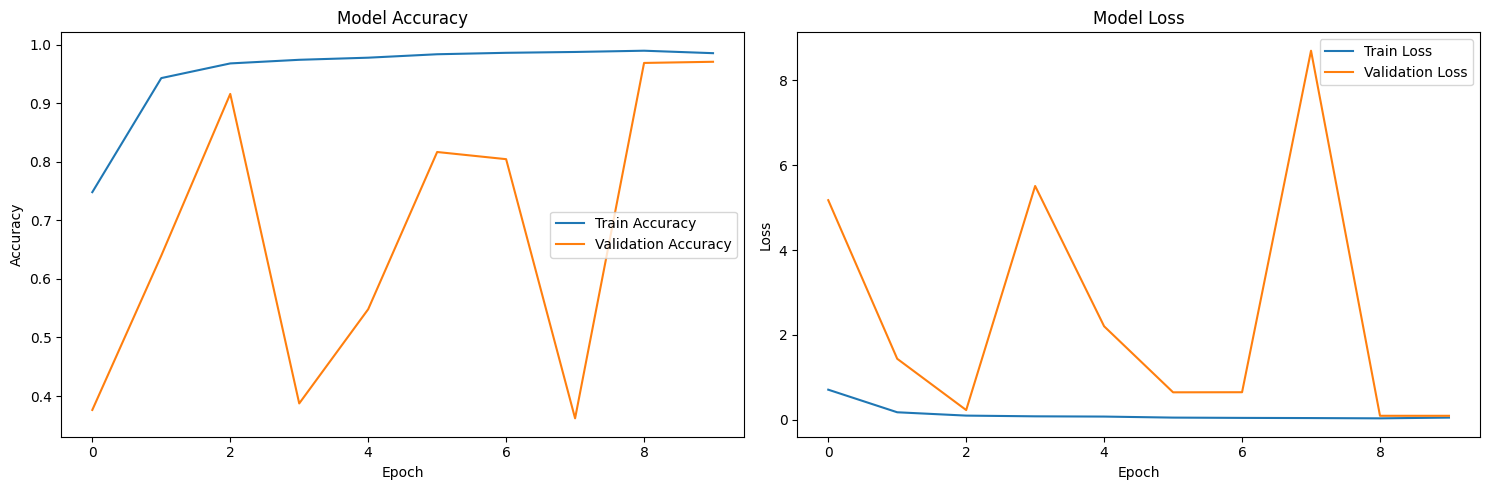


Generating Detailed Evaluation
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Successfully extracted class labels: ['ALMI' 'AMI' 'ASLMI' 'ASMI' 'ILMI' 'IMI' 'IPLMI' 'IPMI' 'LMI' 'NO' 'PLMI'
 'PMI']

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1163
           1       0.96      0.98      0.97      1121
           2       1.00      1.00      1.00        54
           3       0.98      0.96      0.97      2008
           4       1.00      0.95      0.97      1348
           5       0.93      1.00      0.96      2295
           6       1.00      0.95      0.98       473
           7       1.00      1.00      1.00         9
           8       1.00      1.00      1.00        85
           9       0.98      0.97      0.98      3816
          10       0.95      0.99      0.97       125
          11       1.00      1.00      1.00        84

    accuracy                           0.97     12581
   macro avg       0.98 

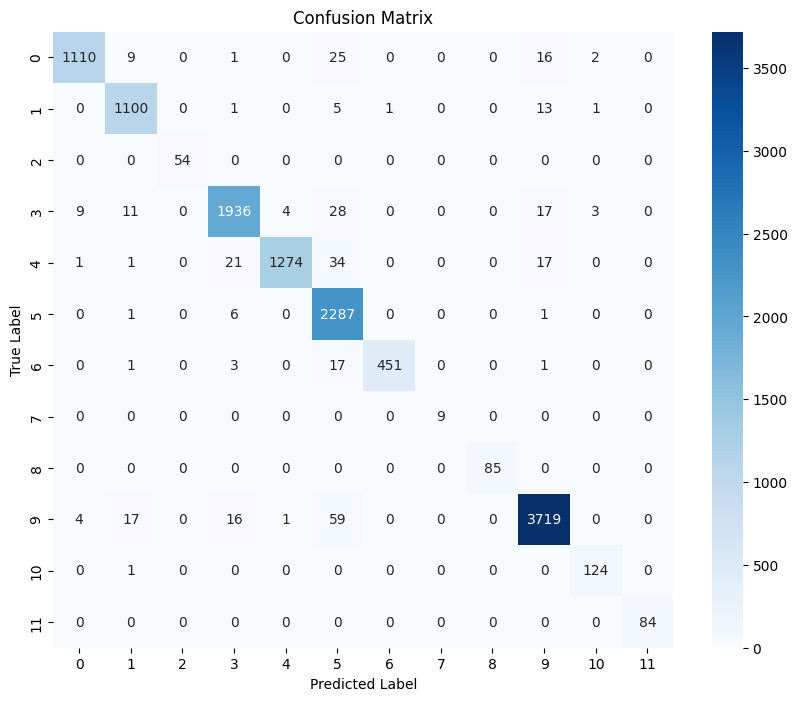

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


print("\n Plot for the accuracy and loss")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot training & validation loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

# Save and display the plot
plt.savefig('training_history.png')
plt.tight_layout()
plt.show()


# --- 2. Detailed Performance Evaluation (Classification Report & Confusion Matrix) ---

print("\nGenerating Detailed Evaluation")

# Get model predictions on the test set
y_pred_probabilities = model.predict(X_test_reshaped)

# Convert probabilities and one-hot encoded labels back to class indices
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
y_true_classes = np.argmax(y_test_final, axis=1)

try:
    class_labels = label_processor.named_transformers_['label_ohe'].named_steps['onehot'].categories_[0]
    print(f"Successfully extracted class labels: {class_labels}")
except AttributeError:
    print("Could not extract labels. Using default numeric labels.")
    # Fallback in case the structure is different
    class_labels = np.arange(num_classes)
    
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

model.save('resnet50_1d_ecg_model.h5')